In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
#from LQN_igraph import *
import itertools
from copy import deepcopy
import sympy as sp
from itertools import groupby
import igraph as ig
import hashlib

import pickle
import igraph as ig # .pkl 파일에 igraph 객체가 포함되어 있으므로 로드 시 필요합니다.
import os
from typing import Dict, List, Any # 타입 힌트를 위해 추가 (선택 사항)

In [2]:
from visualization import *
from graph_analysis import *

In [3]:
from quantum_state_analysis import *

In [4]:
# --- 설정 ---
# 결과 파일이 저장된 디렉토리 경로
# main_script.py 실행 시 --output_dir 옵션을 사용했다면 해당 경로를, 아니면 기본값 'results'를 사용합니다.
output_dir = '/Users/jaeheekim/Desktop/SKKU_PHDS/code/canonical_graph/'

# 로드할 파일의 파라미터 설정 (main_script.py 실행 시 사용했던 값)
num_system = 4
num_ancilla = 2
graph_type = 0

# 로드할 파일 경로 조합
filename = f'bigraph_result_sys{num_system}_anc{num_ancilla}_type{graph_type}.pkl'
file_path = os.path.join(output_dir, filename)

# --- 파일 로드 ---
loaded_data: Dict[str, List[Any]] = {} # 로드된 데이터를 저장할 변수

print(f"'{file_path}' 파일 로드를 시도합니다...")

try:
    # 파일을 바이너리 읽기 모드('rb')로 엽니다.
    with open(file_path, 'rb') as f:
        # pickle.load() 함수를 사용하여 파일에서 데이터를 로드(역직렬화)합니다.
        loaded_data = pickle.load(f)

    print("파일 로드 완료!")

    # --- 로드된 데이터 확인 (선택 사항) ---
    if loaded_data:
        print(f"로드된 데이터 타입: {type(loaded_data)}")
        num_keys = len(loaded_data)
        print(f"데이터에 포함된 고유 구조 해시 키 개수: {num_keys}")

        # 첫 번째 키와 해당 키에 포함된 고유 그래프 개수 확인
        first_key = list(loaded_data.keys())[0]
        num_graphs_in_first_group = len(loaded_data[first_key])
        print(f"첫 번째 그룹(키: '{first_key[:10]}...')에 포함된 고유 그래프 개수: {num_graphs_in_first_group}")

        # 첫 번째 그래프 정보 확인 (igraph 객체)
        if num_graphs_in_first_group > 0:
            first_graph = loaded_data[first_key][0]
            print(f"첫 번째 그룹의 첫 번째 그래프 타입: {type(first_graph)}")
            if isinstance(first_graph, ig.Graph):
                print(f"그래프 요약: {first_graph.summary()}")

    else:
        print("로드된 데이터가 비어 있습니다.")

except FileNotFoundError:
    print(f"오류: 파일을 찾을 수 없습니다. 경로를 확인하세요: '{file_path}'")
except pickle.UnpicklingError:
    print(f"오류: 파일을 로드하는 중 pickle 오류가 발생했습니다. 파일이 손상되었거나 호환되지 않을 수 있습니다.")
except ImportError as e:
    print(f"오류: 데이터를 로드하는 데 필요한 클래스/모듈을 찾을 수 없습니다: {e}")
    print("특히 'igraph' 라이브러리가 현재 환경에 설치되어 있는지 확인하세요.")
except Exception as e:
    print(f"알 수 없는 오류 발생: {e}")



'/Users/jaeheekim/Desktop/SKKU_PHDS/code/canonical_graph/bigraph_result_sys4_anc2_type0.pkl' 파일 로드를 시도합니다...
파일 로드 완료!
로드된 데이터 타입: <class 'dict'>
데이터에 포함된 고유 구조 해시 키 개수: 575
첫 번째 그룹(키: 'f3efd1bb4e...')에 포함된 고유 그래프 개수: 5
첫 번째 그룹의 첫 번째 그래프 타입: <class 'igraph.Graph'>
그래프 요약: IGRAPH UNW- 12 15 -- 
+ attr: bipartite (v), category (v), name (v), weight (e)


In [5]:
# import json
# import os
# import time
# import igraph as ig # igraph 객체 타입을 확인하기 위해 필요할 수 있음

# # --- 설정 (이전 로드 셀에서 정의된 변수 사용) ---
# # output_dir, num_system, num_ancilla, graph_type 변수가
# # 이 셀을 실행하기 전에 정의되어 있어야 합니다.

# # 저장할 JSON 파일 경로 생성
# json_filename = f'bigraph_result_sys{num_system}_anc{num_ancilla}_type{graph_type}.json'
# json_file_path = os.path.join(output_dir, json_filename)

# # --- igraph.Graph 객체를 딕셔너리로 변환하는 함수 ---
# def igraph_to_dict(graph: ig.Graph) -> dict:
#     """igraph.Graph 객체를 JSON 직렬화 가능한 딕셔너리로 변환합니다."""
#     if not isinstance(graph, ig.Graph):
#         # 예상치 못한 타입이 들어올 경우 오류 발생 또는 기본값 반환
#         # 여기서는 간단히 문자열로 처리하거나 에러를 발생시킬 수 있습니다.
#         return {"error": f"Expected igraph.Graph, got {type(graph)}"}

#     nodes = []
#     for v in graph.vs:
#         node_info = v.attributes() # 노드의 모든 속성을 딕셔너리로 가져옴
#         node_info['id'] = v.index  # 노드 인덱스(ID) 추가
#         nodes.append(node_info)

#     edges = []
#     for e in graph.es:
#         edge_info = e.attributes() # 엣지의 모든 속성을 딕셔너리로 가져옴
#         edges.append({
#             "source": e.source,    # 시작 노드 인덱스
#             "target": e.target,    # 끝 노드 인덱스
#             "attributes": edge_info # 엣지 속성 딕셔너리
#         })

#     graph_attrs = graph.attributes() # 그래프 자체의 속성

#     return {
#         "nodes": nodes,
#         "edges": edges,
#         "graph_attributes": graph_attrs
#     }

# # --- 로드된 데이터를 JSON 친화적 형태로 변환 ---
# data_to_save = {}
# conversion_successful = True
# print("\nConverting loaded data to JSON-serializable format...")
# conversion_start_time = time.time()

# # loaded_data 변수가 이전 셀에서 성공적으로 로드되었다고 가정
# if 'loaded_data' in locals() and loaded_data:
#     for key, graph_list in loaded_data.items():
#         serializable_graph_list = []
#         for graph_obj in graph_list:
#             try:
#                 # 각 igraph 객체를 딕셔너리로 변환
#                 converted_graph = igraph_to_dict(graph_obj)
#                 serializable_graph_list.append(converted_graph)
#             except Exception as conv_e:
#                 print(f"Error converting graph in group '{key}': {conv_e}")
#                 # 오류 발생 시 해당 그래프 대신 에러 메시지 추가 또는 건너뛰기
#                 serializable_graph_list.append({"conversion_error": str(conv_e)})
#                 conversion_successful = False # 전체 변환 실패 플래그 설정 (선택 사항)

#         data_to_save[key] = serializable_graph_list
#     conversion_end_time = time.time()
#     print(f"Data conversion finished in {conversion_end_time - conversion_start_time:.2f} seconds.")

# else:
#     print("Error: 'loaded_data' not found or is empty. Cannot proceed with conversion.")
#     conversion_successful = False

# # --- 변환된 데이터를 JSON 파일로 저장 ---
# # 변환이 성공적으로 이루어졌고, 저장할 데이터가 있는 경우에만 진행
# if conversion_successful and data_to_save:
#     print(f"\nSaving converted data to JSON file: '{json_file_path}'...")
#     save_start_time = time.time()
#     try:
#         # 출력 디렉토리 확인 및 생성
#         os.makedirs(output_dir, exist_ok=True)

#         # JSON 파일을 텍스트 쓰기 모드('w')로 열기
#         with open(json_file_path, 'w', encoding='utf-8') as f_json:
#             # 변환된 데이터(딕셔너리 구조)를 JSON으로 저장
#             json.dump(data_to_save, f_json, indent=4) # indent=4는 가독성 향상

#         save_end_time = time.time()
#         print(f"Data saved successfully to JSON in {save_end_time - save_start_time:.2f} seconds.")

#     except PermissionError:
#          print(f"Error: Permission denied when trying to write to {json_file_path}")
#     except TypeError as e:
#         # 이 오류는 변환 함수가 제대로 작동했다면 발생하지 않아야 합니다.
#         # 만약 발생한다면 변환 함수(igraph_to_dict)의 로직 검토 필요
#         print(f"Error: Failed to serialize the converted data to JSON: {e}")
#     except MemoryError:
#          print("Error: Insufficient memory to save the results as JSON.")
#     except Exception as e:
#         print(f"An unexpected error occurred during JSON saving: {e}")
# elif not data_to_save:
#      print("\nSkipping JSON saving because there is no data to save (possibly due to load/conversion failure).")

In [6]:
total_elements = sum(len(v) for v in loaded_data.values())  # 모든 리스트 요소 개수 합산
print(total_elements)  # 출력: 9

8876


In [7]:
# graph_dict contains your dictionary of igraph objects
result_dict = process_graph_dict(loaded_data)

# # Accessing results
# for hash_key, states in result_dict.items():
#     print(f"Hash: {hash_key}")
#     for state in states:
#         counter, matchings, graph, index = state
#         print(f"  State coefficients: {dict(counter)}")

Processing 575 graph groups for quantum states...
Perfect matching analysis complete. Processed: 5, Valid (met conditions): 5, Errors: 0
Removed 0 duplicate states based on Counter content. Kept 5 unique entries.
Perfect matching analysis complete. Processed: 5, Valid (met conditions): 5, Errors: 0
Removed 0 duplicate states based on Counter content. Kept 5 unique entries.
Perfect matching analysis complete. Processed: 28, Valid (met conditions): 28, Errors: 0
Removed 8 duplicate states based on Counter content. Kept 20 unique entries.
Perfect matching analysis complete. Processed: 28, Valid (met conditions): 28, Errors: 0
Removed 8 duplicate states based on Counter content. Kept 20 unique entries.
Perfect matching analysis complete. Processed: 36, Valid (met conditions): 36, Errors: 0
Removed 8 duplicate states based on Counter content. Kept 28 unique entries.
Perfect matching analysis complete. Processed: 36, Valid (met conditions): 36, Errors: 0
Removed 8 duplicate states based on C

In [8]:
result_dict.keys()

dict_keys(['f3efd1bb4e0fcf52c4fdee9368b15a5997923f40c09e00ea87be08e5ab7b7f33', '06e93e165aa9645f3f20a8383ea0370ae0b74d4155c14b10323db9ab48c6379f', '0a8535c0e151062e4a88ab2491608451af6db3d367f7cb4844be4e6117929a3d', 'cd8bb8f6d7c7950c8c30f948fabee0a5722ee7fb42c5ba578e0b3e43c63f4a20', 'c55fcaf884e74e16d3fd1e1cd37aba5a0e3d4c8db9e63e1fa562cfcc0ca15022', 'c51b1de72b631dbe79d25bd82f3adc151526a7b045c87662f793b0fe3c101cae', '0139ef0181a430c874f3adda7eca4d113b8356b62f7234e22cbed2248a1b7399', '98223aa7b023224c00be29c9f25055b0c66f503caa565a11aa874f4737eb9979', 'b451e0c8cbf309cf9ba63b688669a0998f8f5f1784500ec71fdc167b447a9bcf', '3f422f19af2881aea7ef9e17a6aee8f32b9c67de4d9e866918b2371d02305043', '1a20d967fa01dfee65ef6324a33a665ddccd2908e677868a003be8f5073a0131', '5f57f187b2a3925547a4fff7a45434d72fd91dfc9d164f2c53f861029cc9530c', 'd10a6bd0e42fc6e512a3a48747a5f58a13b097ff83ae301d803c0da924f681cd', '5a33cc057d9f365549b12d0fd6ecf463446a51363401702a75d90d9dcddf41ba', 'eab722836c3026acfa62503b2bc34d0f6f8f

In [9]:
list(result_dict.keys())[0]

'f3efd1bb4e0fcf52c4fdee9368b15a5997923f40c09e00ea87be08e5ab7b7f33'

In [10]:
result_dict[list(result_dict.keys())[0]][0][0]

Counter({'0111': 1, '1011': 1, '1101': 1, '1110': 1, '1111': 1})

In [11]:
result_dict[list(result_dict.keys())[0]][0][1]

[[(0, 6, 1.0),
  (1, 8, 2.0),
  (2, 9, 2.0),
  (3, 10, 2.0),
  (4, 11, 3.0),
  (5, 7, 3.0)],
 [(0, 7, 2.0),
  (1, 6, 1.0),
  (2, 9, 2.0),
  (3, 10, 2.0),
  (4, 11, 3.0),
  (5, 8, 3.0)],
 [(0, 7, 2.0),
  (1, 8, 2.0),
  (2, 6, 1.0),
  (3, 10, 2.0),
  (4, 11, 3.0),
  (5, 9, 3.0)],
 [(0, 7, 2.0),
  (1, 8, 2.0),
  (2, 9, 2.0),
  (3, 6, 1.0),
  (4, 11, 3.0),
  (5, 10, 3.0)],
 [(0, 7, 2.0),
  (1, 8, 2.0),
  (2, 9, 2.0),
  (3, 10, 2.0),
  (4, 6, 3.0),
  (5, 11, 3.0)]]

In [12]:
# 예제 2: 여러 상태 검색 (특정 비트 위치만 플립)
target_states = ['0000', '1100', '0011', '1111'] 
filtered_results = check_quantum_states_with_bit_flips(result_dict, target_states, bit_flip_positions=None, exact_num_states=4)

In [19]:
filtered_results[4]

('3065adda478c76fb3b42d853230a914ed1340b29bdfc6fa184088abd3e9716d3',
 0,
 [[(0, 6, 1.0),
   (1, 8, 2.0),
   (2, 9, 1.0),
   (3, 11, 2.0),
   (4, 7, 3.0),
   (5, 10, 3.0)],
  [(0, 6, 1.0),
   (1, 8, 2.0),
   (2, 9, 1.0),
   (3, 11, 2.0),
   (4, 10, 3.0),
   (5, 7, 3.0)],
  [(0, 6, 1.0),
   (1, 8, 2.0),
   (2, 10, 2.0),
   (3, 9, 1.0),
   (4, 7, 3.0),
   (5, 11, 3.0)],
  [(0, 7, 2.0),
   (1, 6, 1.0),
   (2, 9, 1.0),
   (3, 11, 2.0),
   (4, 8, 3.0),
   (5, 10, 3.0)],
  [(0, 7, 2.0),
   (1, 6, 1.0),
   (2, 10, 2.0),
   (3, 9, 1.0),
   (4, 8, 3.0),
   (5, 11, 3.0)]],
 Counter({'0101': 2, '0110': 1, '1001': 1, '1010': 1}),
 [0, 2],
 {'1010': 1, '0110': 1, '1001': 1, '0101': 2})

In [13]:
len(filtered_results)

29

In [14]:
final_analysis_output = perform_final_signed_analysis(filtered_results)


Starting Stage 3: Performing 2^K analysis on 29 filtered graph entries...
  Processing filtered entry 0: Key='4a83a72b0f9f97e411b68ebe6169cb917cf71862abfee133499a779c47c82181', Index=2
    Found 4 PM structures.
DEBUG: Found 4 PM structures involving 14 unique edges.
    Successfully generated 16384 (sign_tuple, state_vector) pairs.
  Processing filtered entry 1: Key='4a83a72b0f9f97e411b68ebe6169cb917cf71862abfee133499a779c47c82181', Index=3
    Found 4 PM structures.
DEBUG: Found 4 PM structures involving 14 unique edges.
    Successfully generated 16384 (sign_tuple, state_vector) pairs.
  Processing filtered entry 2: Key='4a83a72b0f9f97e411b68ebe6169cb917cf71862abfee133499a779c47c82181', Index=9
    Found 4 PM structures.
DEBUG: Found 4 PM structures involving 14 unique edges.
    Successfully generated 16384 (sign_tuple, state_vector) pairs.
  Processing filtered entry 3: Key='4a83a72b0f9f97e411b68ebe6169cb917cf71862abfee133499a779c47c82181', Index=10
    Found 4 PM structures.
DEB

In [15]:
final_analysis_output[0]

{'hash_key': '4a83a72b0f9f97e411b68ebe6169cb917cf71862abfee133499a779c47c82181',
 'graph_index': 2,
 'graph': <igraph.Graph at 0x16a4d5150>,
 'ordered_unique_edges': [(4, 10),
  (0, 7),
  (5, 11),
  (5, 8),
  (2, 10),
  (1, 8),
  (5, 7),
  (0, 6),
  (2, 9),
  (3, 9),
  (4, 8),
  (1, 6),
  (4, 7),
  (3, 11)],
 'signed_states_results': [((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1),
   Counter({'0101': 1, '0110': 1, '1001': 1, '1010': 1})),
  ((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1),
   Counter({'0110': 1, '1010': 1, '0101': -1, '1001': -1})),
  ((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1),
   Counter({'0101': 1, '1001': 1, '1010': 1, '0110': -1})),
  ((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1),
   Counter({'1010': 1, '0101': -1, '0110': -1, '1001': -1})),
  ((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1),
   Counter({'0101': 1, '0110': 1, '1001': -1, '1010': -1})),
  ((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1),
   Counter({'0110': 1, '1001': 1, '0101': -1, '1010': -1})),
  ((1, 1, 1,

In [16]:
len(list(final_analysis_output[0].keys()))

7

In [17]:
list(final_analysis_output[0].keys())

['hash_key',
 'graph_index',
 'graph',
 'ordered_unique_edges',
 'signed_states_results',
 'pm_to_base_state',
 'applied_bit_flips']

In [19]:
final_analysis_output[0]['pm_to_base_state']

[([(0, 6), (1, 8), (2, 9), (3, 11), (4, 10), (5, 7)], '0101'),
 ([(0, 6), (1, 8), (2, 10), (3, 9), (4, 7), (5, 11)], '0110'),
 ([(0, 7), (1, 6), (2, 9), (3, 11), (4, 10), (5, 8)], '1001'),
 ([(0, 7), (1, 6), (2, 10), (3, 9), (4, 8), (5, 11)], '1010')]

In [20]:
list(final_analysis_output[0].keys())[4]

'signed_states_results'

In [21]:
final_analysis_output[0][list(final_analysis_output[0].keys())[4]]

[((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1),
  Counter({'0101': 1, '0110': 1, '1001': 1, '1010': 1})),
 ((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1),
  Counter({'0110': 1, '1010': 1, '0101': -1, '1001': -1})),
 ((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1),
  Counter({'0101': 1, '1001': 1, '1010': 1, '0110': -1})),
 ((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1),
  Counter({'1010': 1, '0101': -1, '0110': -1, '1001': -1})),
 ((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1),
  Counter({'0101': 1, '0110': 1, '1001': -1, '1010': -1})),
 ((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1),
  Counter({'0110': 1, '1001': 1, '0101': -1, '1010': -1})),
 ((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1),
  Counter({'0101': 1, '0110': -1, '1001': -1, '1010': -1})),
 ((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1),
  Counter({'1001': 1, '0101': -1, '0110': -1, '1010': -1})),
 ((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1),
  Counter({'0101': 1, '0110': 1, '1001': 1, '1010': -1})),
 ((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -

In [22]:
filtered_results_odd = filter_results_by_odd_negatives(final_analysis_output)


Starting filtering based on odd negative coefficients on 29 graph entries...
  Keeping entry Key='4a83a72b0f9f97e411b68ebe6169cb917cf71862abfee133499a779c47c82181', Index=2: Found 8192 states with odd negative coeffs.
  Keeping entry Key='4a83a72b0f9f97e411b68ebe6169cb917cf71862abfee133499a779c47c82181', Index=3: Found 8192 states with odd negative coeffs.
  Keeping entry Key='4a83a72b0f9f97e411b68ebe6169cb917cf71862abfee133499a779c47c82181', Index=9: Found 8192 states with odd negative coeffs.
  Keeping entry Key='4a83a72b0f9f97e411b68ebe6169cb917cf71862abfee133499a779c47c82181', Index=10: Found 8192 states with odd negative coeffs.
  Keeping entry Key='3065adda478c76fb3b42d853230a914ed1340b29bdfc6fa184088abd3e9716d3', Index=0: Found 4096 states with odd negative coeffs.
  Keeping entry Key='3065adda478c76fb3b42d853230a914ed1340b29bdfc6fa184088abd3e9716d3', Index=1: Found 4096 states with odd negative coeffs.
  Keeping entry Key='3065adda478c76fb3b42d853230a914ed1340b29bdfc6fa184088a

In [24]:
len(filtered_results_odd)

29

In [29]:
filtered_results_odd[4]['signed_states_results']

[((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1),
  Counter({'1001': 1, '1010': 1, '0110': -1})),
 ((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1),
  Counter({'0110': -1, '1001': -1, '1010': -1})),
 ((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, 1),
  Counter({'0110': -1, '1001': -1, '1010': -1})),
 ((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, 1),
  Counter({'1001': 1, '1010': 1, '0110': -1})),
 ((1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1),
  Counter({'0110': 1, '1001': 1, '1010': -1})),
 ((1, 1, 1, 1, 1, 1, 1, 1, 1, -1, 1, -1, -1, 1),
  Counter({'0110': 1, '1010': 1, '1001': -1})),
 ((1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, 1, -1, 1),
  Counter({'0110': 1, '1010': 1, '1001': -1})),
 ((1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, 1),
  Counter({'0110': 1, '1001': 1, '1010': -1})),
 ((1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1),
  Counter({'0110': 1, '1010': 1, '1001': -1})),
 ((1, 1, 1, 1, 1, 1, 1, 1, -1, 1, 1, -1, 1, 1),
  Counter({'0110': 1, '1001': 1, '1010': -1})),
 ((1, 1, 1, 1, 1, 1, 1, 1, -1, 1,

In [25]:
len(filtered_results_odd[0]['signed_states_results'])

8192

Attempting to draw bipartite graph: IGRAPH UNW- 12 14 -- 
+ attr: bipartite (v), category (v), name (v), weight (e)


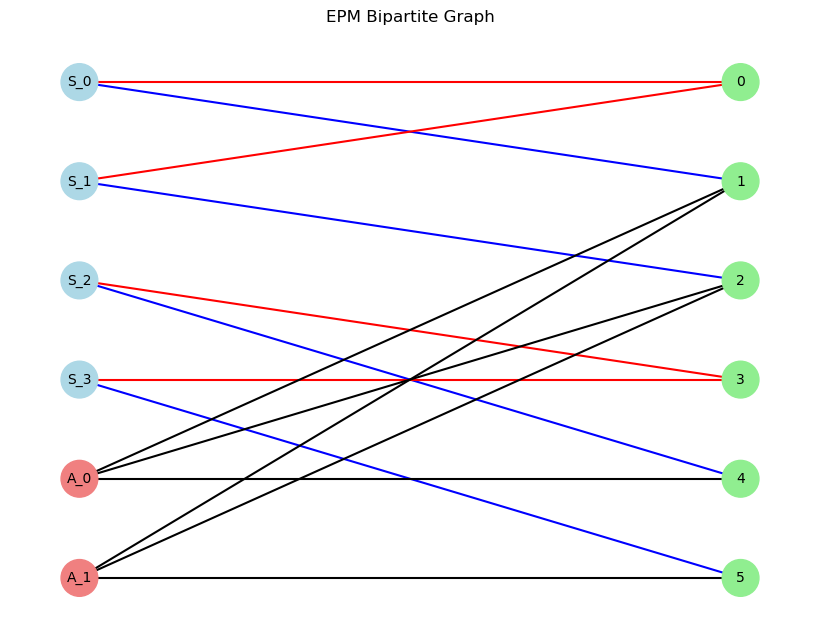

In [20]:
Draw_EPM_bipartite_graph(final_analysis_output[0][list(final_analysis_output[0].keys())[2]])

In [ ]:
Draw_EPM_biparti

Attempting to draw bipartite graph: IGRAPH UNW- 12 14 -- 
+ attr: bipartite (v), category (v), name (v), weight (e)


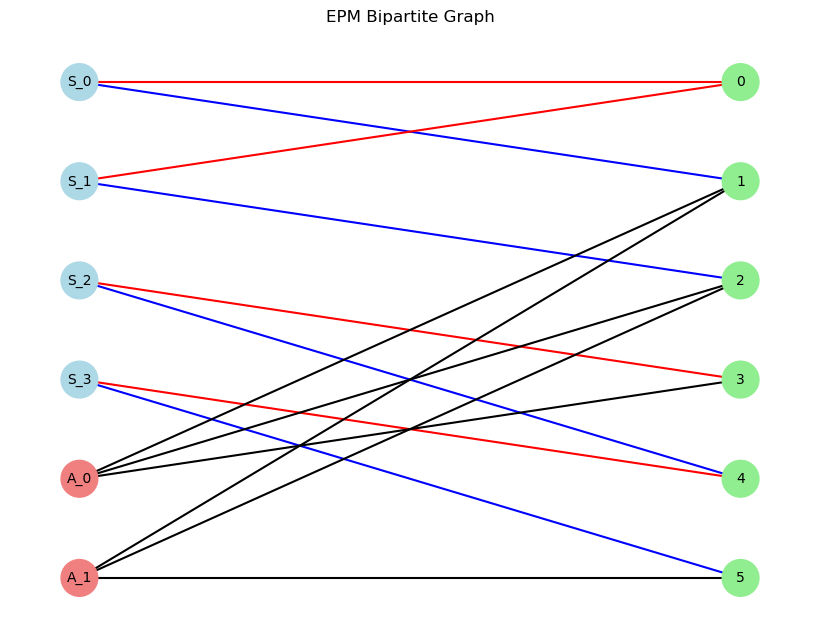

In [14]:
Draw_EPM_bipartite_graph(results[1][1])

In [15]:
# import matplotlib.pyplot as plt
# import os # Import the os module for file path/directory management
# # Import the visualization module (containing the modified function)
# from visualization import Draw_EPM_bipartite_graph # , Draw_EPM_digraph (if needed and modified)

# # --- Preparation ---
# # 1. The function Draw_EPM_bipartite_graph must be defined (and modified).
# # 2. The variable 'results' must be defined.

# # Set the directory name to save PDF files
# save_directory = "bipartite_graph_pdfs"

# # Create the directory if it does not exist
# if not os.path.exists(save_directory):
#     os.makedirs(save_directory)
#     print(f"Directory '{save_directory}' created.")

# # --- Main Loop ---
# num_plots = 29 # Total number of plots

# for i in range(num_plots):
#     print(f"Processing plot index: {i}")

#     # **** Explicitly create Figure and Axes objects ****
#     # **** figsize can be fixed here, or calculated dynamically if needed ****
#     fig, ax = plt.subplots(figsize=(8, 6)) # Example fixed size

#     # 1. Generate the plot on the specific axes
#     try:
#         # **** Call modified function: pass ax=ax ****
#         Draw_EPM_bipartite_graph(results[i][1], ax=ax)

#     except Exception as e:
#         print(f"  Error: Failed to generate plot for index {i}: {e}")
#         # **** Close the explicitly created fig ****
#         plt.close(fig) # Close the specific figure created for this iteration on error
#         continue

#     # 2. Define the filename for saving
#     pdf_filename = f"bipartite_graph_{i}.pdf"
#     full_path = os.path.join(save_directory, pdf_filename)

#     # 3. Save the specific figure object 'fig'
#     try:
#         # **** Use fig.savefig instead of plt.savefig ****
#         fig.savefig(full_path, format='pdf', bbox_inches='tight')
#         print(f"  Success: Plot saved to '{full_path}'")
#     except Exception as e:
#         print(f"  Error: Failed to save plot for index {i}: {e}")
#     finally:
#         # 4. Close the specific figure 'fig'
#         # **** Use plt.close(fig) instead of plt.close() ****
#         plt.close(fig) # Close the specific figure object created for this iteration

# print(f"\nFinished saving PDF files for {num_plots} plots.")

In [16]:
adj = results[0][1].get_adjacency()

In [17]:
adj.data

[[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
 [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1],
 [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]]

In [18]:
np.array(adj.data)

array([[0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1],
       [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]])

In [19]:
type(results[0][1].get_adjacency())

igraph.datatypes.Matrix

In [20]:
adj = results[0][1].get_adjacency(attribute="weight")

In [21]:
adj.data
# red = 1, blue = 2, black = 3

[[0, 0, 0, 0, 0, 0, 1.0, 2.0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1.0, 0, 2.0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 2.0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1.0, 0, 2.0],
 [0, 0, 0, 0, 0, 0, 0, 3.0, 3.0, 0, 3.0, 0],
 [0, 0, 0, 0, 0, 0, 0, 3.0, 3.0, 0, 0, 3.0],
 [1.0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [2.0, 0, 0, 0, 3.0, 3.0, 0, 0, 0, 0, 0, 0],
 [0, 2.0, 0, 0, 3.0, 3.0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1.0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 2.0, 0, 3.0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 2.0, 0, 3.0, 0, 0, 0, 0, 0, 0]]

In [22]:
adj_di = EPM_digraph_from_EPM_bipartite_graph_igraph(results[0][1])

In [23]:
adj_di.get_adjacency(attribute="weight").data

[[np.float64(1.0), np.float64(2.0), 0, 0, 0, 0],
 [np.float64(1.0), 0, np.float64(2.0), 0, 0, 0],
 [0, 0, 0, np.float64(1.0), np.float64(2.0), 0],
 [0, 0, 0, np.float64(1.0), 0, np.float64(2.0)],
 [0, np.float64(3.0), np.float64(3.0), 0, np.float64(3.0), 0],
 [0, np.float64(3.0), np.float64(3.0), 0, 0, np.float64(3.0)]]

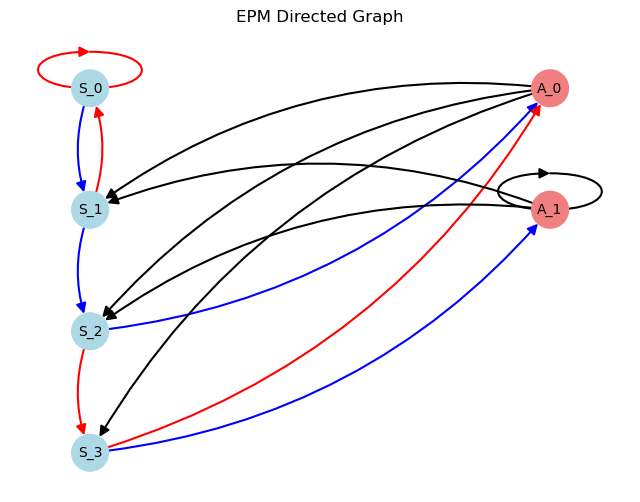

In [24]:
Draw_EPM_digraph(EPM_digraph_from_EPM_bipartite_graph_igraph(results[1][1]))

Attempting to draw bipartite graph: IGRAPH UNW- 12 14 -- 
+ attr: bipartite (v), category (v), name (v), weight (e)


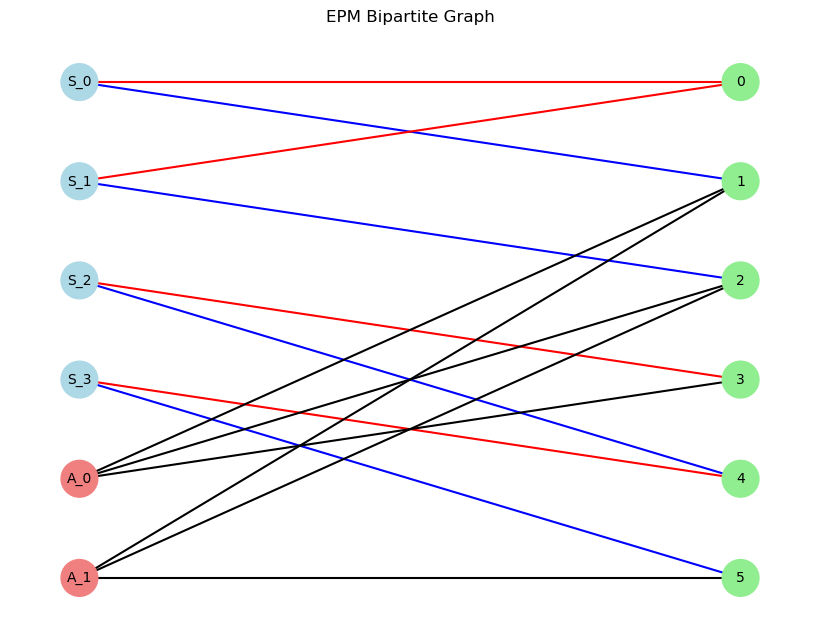

In [25]:
Draw_EPM_bipartite_graph(results[1][1])

In [27]:
# # Set directory name for saving PDF files
# save_directory = "digraph_pdfs"

# # Create directory if it doesn't exist
# if not os.path.exists(save_directory):
#     os.makedirs(save_directory)
#     print(f"Directory '{save_directory}' created.")

# # --- Main Loop ---
# num_plots = 29 # Total number of graphs (set according to the length of results list)

# for i in range(num_plots):
#     print(f"Processing digraph plot index: {i}")

#     # **** Create new Figure and Axes objects for each iteration ****
#     fig, ax = plt.subplots(figsize=(10, 8)) # Set appropriate size for digraph

#     try:
#         # 1. Get bipartite graph B
#         B = results[i][1] # Adjust index according to results structure if needed

#         # 2. Create directed graph D
#         #    (If D is already in results[i], skip this step and use that D)
#         D = EPM_digraph_from_EPM_bipartite_graph_igraph(B)

#         # 3. Draw graph on specific ax
#         #    Call modified Draw_EPM_digraph function (pass ax)
#         #    Can set graph title (e.g., f"Digraph {i}")
#         Draw_EPM_digraph(D, title=f"EPM Directed Graph {i}", ax=ax)

#     except Exception as e:
#         print(f"  Error: Failed to generate or draw digraph for index {i}: {e}")
#         # **** Close fig if error occurs ****
#         plt.close(fig)
#         continue

#     # 4. Define filename to save
#     pdf_filename = f"digraph_{i}.pdf"
#     full_path = os.path.join(save_directory, pdf_filename)

#     # 5. Save the created Figure object 'fig'
#     try:
#         # **** Use fig.savefig ****
#         fig.savefig(full_path, format='pdf', bbox_inches='tight')
#         print(f"  Success: Digraph plot saved to '{full_path}'")
#     except Exception as e:
#         print(f"  Error: Failed to save digraph plot for index {i}: {e}")
#     finally:
#         # 6. Close the created Figure 'fig' (free memory)
#         # **** Use plt.close(fig) ****
#         plt.close(fig)

# print(f"\nFinished saving PDF files for {num_plots} digraph plots.")